# 0. Reading the Data
I will start with ride ID = 2975587283 which is the first ride of 2020 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 100)

In [2]:
file_paths = {'in':'../../data/processed/activities/2975587283.csv'
             }

In [3]:
df = pd.read_csv(file_paths['in'])

# guarantee the timestamps are datetime objects
df['time'] = pd.to_datetime(df['time'])

In [4]:
df.head()

,ride_id,segment_id,time,elevation,latitude,longitude
0,2975587283,-1,2020-01-02 14:02:58+00:00,224.3,40.042824,-83.027358
1,2975587283,-1,2020-01-02 14:03:00+00:00,224.2,40.042877,-83.027490
2,2975587283,-1,2020-01-02 14:03:02+00:00,224.2,40.042914,-83.027581
3,2975587283,-1,2020-01-02 14:03:04+00:00,224.2,40.042934,-83.027644
4,2975587283,-1,2020-01-02 14:06:04+00:00,224.2,40.042900,-83.027659


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   ride_id     872 non-null    int64              
 1   segment_id  872 non-null    int64              
 2   time        872 non-null    datetime64[ns, UTC]
 3   elevation   872 non-null    float64            
 4   latitude    872 non-null    float64            
 5   longitude   872 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(3), int64(2)
memory usage: 41.0 KB


# 1. Creating Delta Time

In [6]:
# first ensure that the dataframe is chronologically sorted
df = df.set_index('time').sort_index().reset_index()

In [7]:
# Temporarily get the number of seconds since Jan. 1, 1970 as the UTC timestamp
df['time_utc'] = df['time'].apply(lambda x: x.timestamp())

In [8]:
# Calculate the row-wise difference in time (in seconds)
df['delta_time'] = df['time_utc'].diff()

In [9]:
df.head()

,time,ride_id,segment_id,elevation,latitude,longitude,time_utc,delta_time
0,2020-01-02 14:02:58+00:00,2975587283,-1,224.3,40.042824,-83.027358,1.577974e+09,NaN
1,2020-01-02 14:03:00+00:00,2975587283,-1,224.2,40.042877,-83.027490,1.577974e+09,2.0
2,2020-01-02 14:03:02+00:00,2975587283,-1,224.2,40.042914,-83.027581,1.577974e+09,2.0
3,2020-01-02 14:03:04+00:00,2975587283,-1,224.2,40.042934,-83.027644,1.577974e+09,2.0
4,2020-01-02 14:06:04+00:00,2975587283,-1,224.2,40.042900,-83.027659,1.577974e+09,180.0


In [10]:
df['delta_time'].value_counts()

2.0      455
1.0      403
3.0        8
180.0      1
23.0       1
15.0       1
10.0       1
29.0       1
Name: delta_time, dtype: int64

In [11]:
# drop the temporary time column
df.drop(['time_utc'], axis=1, inplace=True)

In [12]:
# fill in the initial value of delta_time with 1.0
df['delta_time'] = df['delta_time'].fillna(1.0)

In [32]:
# Capturing this as a function to re-use later
def create_delta_time(df, time_column='time', fill_first=1.0):
    # Temporarily get the number of seconds since Jan. 1, 1970 as the UTC timestamp
    df['time_utc'] = df[time_column].apply(lambda x: x.timestamp())
    
    # Calculate the row-wise difference in time (in seconds)
    df['delta_time'] = df['time_utc'].diff()
    
    # drop the temporary time column
    df.drop(['time_utc'], axis=1, inplace=True)
    
    # fill in the initial value of delta_time with @fill_first
    df['delta_time'] = df['delta_time'].fillna(fill_first)
    
    return df['delta_time']

# 2. Creating the Elapsed Time Column

In [13]:
# create an elapsed time column
df['elapsed_time'] = df['delta_time'].cumsum()

# 3. Visualize the Row-wise Time Discontinuities

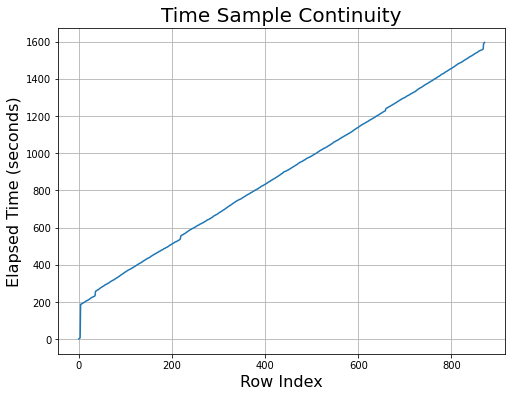

In [14]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(8,6))

_ = plt.plot(df['elapsed_time'])
_ = plt.xlabel('Row Index', fontsize=16)
_ = plt.ylabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.title('Time Sample Continuity', fontsize=20)
_ = plt.grid()

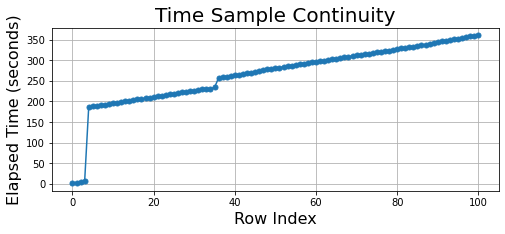

In [15]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(8,3))

_ = plt.plot(df.loc[0:100, 'elapsed_time'], linestyle='-', marker='.', markersize=10)
_ = plt.xlabel('Row Index', fontsize=16)
_ = plt.ylabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.title('Time Sample Continuity', fontsize=20)
_ = plt.grid()

### Are there major discontinuities in Localization States?

In [16]:
def get_time_gap_indices(df, time_gap_threshold=15):
    # Calculate when the time discontinuities occur
    filt_time_jump = df['delta_time'] >= time_gap_threshold
    time_gap_indices = list(df.loc[filt_time_jump, 'time'].index)
    return time_gap_indices

In [17]:
time_gap_indices = get_time_gap_indices(df, time_gap_threshold=15)

In [18]:
def plot_state_by_index(df, state_column, discontinuities, figsize=(8,3), row_bounds=None, y_lim_scale=0.005):
    fig = plt.figure(figsize=figsize)
    # Mark the discontinuities
    for discont_index in discontinuities:
        _ = plt.axvline(discont_index, color='r')
    
    # Plot the state
    _ = plt.plot(df.loc[:, state_column], linestyle='-', marker='.', markersize=10)
    _ = plt.xlabel('Row Index', fontsize=16)
    _ = plt.ylabel(f'{state_column}', fontsize=16)
    _ = plt.title(f'Time Sample Continuity of {state_column}', fontsize=20)
    _ = plt.grid()
    
    # Manage the axes limits
    if row_bounds is not None:
        _ = plt.xlim(row_bounds)
    else:
        row_bounds = [0, df.shape[0]-1]
        
    y_min = np.min(df.loc[row_bounds, state_column])
    y_max = np.max(df.loc[row_bounds, state_column])
    
    _ = plt.ylim([(1-y_lim_scale)*y_min, (1+y_lim_scale)*y_max])
    

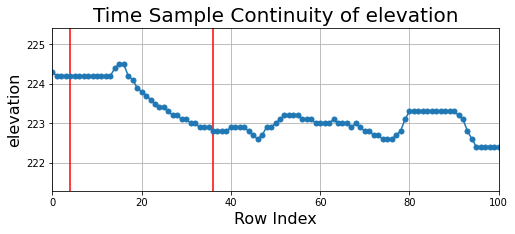

In [19]:
plot_state_by_index(df, 'elevation', time_gap_indices, row_bounds=[0, 100])

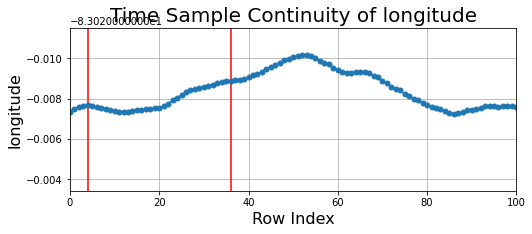

In [20]:
plot_state_by_index(df, 'longitude', time_gap_indices, row_bounds=[0, 100], y_lim_scale=0.00005)

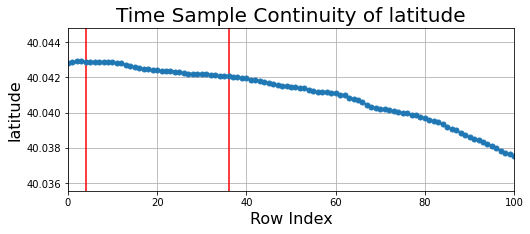

In [21]:
plot_state_by_index(df, 'latitude', time_gap_indices, row_bounds=[0, 100], y_lim_scale=0.00005)

# 4. Segment ID Creation
For every segment of the ride where `delta_time` < `time_gap_threshold`, we need to assign it a locally unique, increasing ID. 

For a segment to be globally unique, concatentate the `ride_id` and `segment_id`

In [22]:
df.head()

,time,ride_id,segment_id,elevation,latitude,longitude,delta_time,elapsed_time
0,2020-01-02 14:02:58+00:00,2975587283,-1,224.3,40.042824,-83.027358,1.0,1.0
1,2020-01-02 14:03:00+00:00,2975587283,-1,224.2,40.042877,-83.027490,2.0,3.0
2,2020-01-02 14:03:02+00:00,2975587283,-1,224.2,40.042914,-83.027581,2.0,5.0
3,2020-01-02 14:03:04+00:00,2975587283,-1,224.2,40.042934,-83.027644,2.0,7.0
4,2020-01-02 14:06:04+00:00,2975587283,-1,224.2,40.042900,-83.027659,180.0,187.0


In [23]:
# get the time gap indices
time_gap_indices = get_time_gap_indices(df, time_gap_threshold=15)

# intialize the initial segment_id. to be incremented for each region of continuous data
segment_id_counter = 0
# initialize the starting index of the first segment
segment_start_index = 0

for time_gap_index in time_gap_indices:
    # Assign the Segment ID
    df.loc[segment_start_index:time_gap_index-1, 'segment_id'] = segment_id_counter
    
    # update the segment_id counter and start index
    segment_id_counter += 1
    segment_start_index = time_gap_index
    
# Since segment_id == -1 by default, this represents the final segment of activity once parsed
df['segment_id'] = df['segment_id'].replace({-1:segment_id_counter})

# Since the delta_time column is no longer needed to detect discontinuities,
# Drop delta_time so we can rebuild it at a segment_id level
df.drop(['delta_time'], axis=1, inplace=True)

In [24]:
time_gap_indices

[4, 36, 219, 869]

In [25]:
df.head(10)

,time,ride_id,segment_id,elevation,latitude,longitude,elapsed_time
0,2020-01-02 14:02:58+00:00,2975587283,0,224.3,40.042824,-83.027358,1.0
1,2020-01-02 14:03:00+00:00,2975587283,0,224.2,40.042877,-83.027490,3.0
2,2020-01-02 14:03:02+00:00,2975587283,0,224.2,40.042914,-83.027581,5.0
3,2020-01-02 14:03:04+00:00,2975587283,0,224.2,40.042934,-83.027644,7.0
4,2020-01-02 14:06:04+00:00,2975587283,1,224.2,40.042900,-83.027659,187.0
5,2020-01-02 14:06:05+00:00,2975587283,1,224.2,40.042889,-83.027639,188.0
6,2020-01-02 14:06:07+00:00,2975587283,1,224.2,40.042880,-83.027603,190.0
7,2020-01-02 14:06:08+00:00,2975587283,1,224.2,40.042873,-83.027558,191.0
8,2020-01-02 14:06:09+00:00,2975587283,1,224.2,40.042868,-83.027484,192.0
9,2020-01-02 14:06:11+00:00,2975587283,1,224.2,40.042868,-83.027436,194.0


In [26]:
df.tail(10)

,time,ride_id,segment_id,elevation,latitude,longitude,elapsed_time
862,2020-01-02 14:28:49+00:00,2975587283,3,223.7,40.043144,-83.027953,1552.0
863,2020-01-02 14:28:50+00:00,2975587283,3,223.7,40.043104,-83.027921,1553.0
864,2020-01-02 14:28:51+00:00,2975587283,3,223.7,40.043072,-83.027885,1554.0
865,2020-01-02 14:28:52+00:00,2975587283,3,223.7,40.043038,-83.027843,1555.0
866,2020-01-02 14:28:53+00:00,2975587283,3,223.7,40.043006,-83.027813,1556.0
867,2020-01-02 14:28:55+00:00,2975587283,3,223.8,40.042975,-83.027800,1558.0
868,2020-01-02 14:28:57+00:00,2975587283,3,223.8,40.042950,-83.027788,1560.0
869,2020-01-02 14:29:26+00:00,2975587283,4,223.8,40.042963,-83.027746,1589.0
870,2020-01-02 14:29:29+00:00,2975587283,4,223.8,40.042928,-83.027765,1592.0
871,2020-01-02 14:29:32+00:00,2975587283,4,223.8,40.042954,-83.027747,1595.0


In [27]:
df['segment_id'].value_counts()

3    650
2    183
1     32
0      4
4      3
Name: segment_id, dtype: int64

# 5. Time Resampling

In [28]:
# set the timestamp as the index for the dataframe
df = df.set_index('time')

In [29]:
df.head()

,ride_id,segment_id,elevation,latitude,longitude,elapsed_time
time,,,,,,
2020-01-02 14:02:58+00:00,2975587283,0,224.3,40.042824,-83.027358,1.0
2020-01-02 14:03:00+00:00,2975587283,0,224.2,40.042877,-83.027490,3.0
2020-01-02 14:03:02+00:00,2975587283,0,224.2,40.042914,-83.027581,5.0
2020-01-02 14:03:04+00:00,2975587283,0,224.2,40.042934,-83.027644,7.0
2020-01-02 14:06:04+00:00,2975587283,1,224.2,40.042900,-83.027659,187.0


In [30]:
df.shape

(872, 6)

In [31]:
# Test resampling to 1 second across the entire dataframe
df.resample('S').interpolate(method ='linear', limit_direction ='forward')

,ride_id,segment_id,elevation,latitude,longitude,elapsed_time
time,,,,,,
2020-01-02 14:02:58+00:00,2.975587e+09,0.0,224.30,40.042824,-83.027358,1.0
2020-01-02 14:02:59+00:00,2.975587e+09,0.0,224.25,40.042851,-83.027424,2.0
2020-01-02 14:03:00+00:00,2.975587e+09,0.0,224.20,40.042877,-83.027490,3.0
2020-01-02 14:03:01+00:00,2.975587e+09,0.0,224.20,40.042896,-83.027535,4.0
2020-01-02 14:03:02+00:00,2.975587e+09,0.0,224.20,40.042914,-83.027581,5.0
...,...,...,...,...,...,...
2020-01-02 14:29:28+00:00,2.975587e+09,4.0,223.80,40.042940,-83.027759,1591.0
2020-01-02 14:29:29+00:00,2.975587e+09,4.0,223.80,40.042928,-83.027765,1592.0
2020-01-02 14:29:30+00:00,2.975587e+09,4.0,223.80,40.042937,-83.027759,1593.0


In [37]:
# Pandas equivalent of a Window Function in SQL
def apply_func_over_window(df, func, partition_by, order_by):
    partition_dict = _partition_dataframe(df, partition_by=partition_by)
    partition_dict = _apply_to_partitions(partition_dict=partition_dict, func=func)
    df = _combine_partitions(partition_dict=partition_dict, order_by=order_by)
    return df

def _partition_dataframe(df, partition_by):
    df_grouped = df.groupby(partition_by)
    groups = df_grouped.groups.keys()
    # build the partitioned dataframe where key=categories of @on_column
    # and the values are the dataframes where @on_column == category_i
    partition_dict = {group:df_grouped.get_group(group) for group in groups}
    return partition_dict

def _apply_to_partitions(partition_dict, func):
    for partition in partition_dict.keys():
        # For each group/partition of the partition
        partition_dict[partition] = func(partition_dict[partition])
    return partition_dict

def _combine_partitions(partition_dict, order_by):
    # Gather the various dataframes of each partition
    dataframes = [df_partition for df_partition in partition_dict.values()]
    df = pd.concat(dataframes)
    # sort the rows by @sort_by
    df = df.set_index(order_by).sort_index().reset_index()
    return df

In [42]:
import pandas as pd
from typing import Callable, Dict, List, Optional, Any
# Type Aliases
Dataframe = pd.DataFrame
Transform = Callable[[Dataframe], Dataframe] # f: Dataframe -> Dataframe
Partition = Dict[Any, Dataframe]

class PandasWindow():
    def __init__(self, partition_by:str, order_by:str) -> None:
        self.partition_by = partition_by
        self.order_by = order_by
    
    def apply_func(self, df:Dataframe, func:Transform) -> Dataframe:
        # PARTITION
        partition_dict = self._partition_dataframe(df)
        # APPLY
        partition_dict = self._apply_to_partitions(partition_dict=partition_dict, func=func)
        # COMBINE
        df = self._combine_partitions(partition_dict=partition_dict)
        return df
    
    def _partition_dataframe(self, df:Dataframe) -> Partition:
        df_grouped = df.groupby(self.partition_by)
        groups = df_grouped.groups.keys()
        # build the partitioned dataframe where key=categories of @on_column
        # and the values are the dataframes where @on_column == category_i
        partition_dict = {group:df_grouped.get_group(group) for group in groups}
        return partition_dict
    
    @staticmethod
    def _apply_to_partitions(partition_dict:Partition, func:Transform) -> Partition:
        for partition in partition_dict.keys():
            # For each group/partition of the partition
            partition_dict[partition] = func(partition_dict[partition])
        return partition_dict
    
    def _combine_partitions(self, partition_dict:Partition) -> Dataframe:
        # Gather the various dataframes of each partition
        dataframes = [df_partition for df_partition in partition_dict.values()]
        df = pd.concat(dataframes)
        # sort the rows by @sort_by
        df = df.set_index(self.order_by).sort_index().reset_index()
        return df
        
    